# 인스타그램 로그인
<hr>
아래에 정의된 함수들을 한 번씩만 실시하고, 이 함수를 사용한 코드들을 모아둔 코드에서 크롤링을 실시하기
위의 코드들은 함수를 미리 정의하여, 크롤링 사용에 용이하도록 만든 코드들임

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import re

# 크롬 브라우저 열기
driver = webdriver.Chrome('C:/Temp/chromedriver')

driver.get("https://www.instagram.com/accounts/login/")
time.sleep(2)

email = '본인 ID'
input_id = driver.find_elements_by_css_selector('input._2hvTZ.pexuQ.zyHYP')[0]
input_id.clear()
input_id.send_keys(email)

password = '본인 PWD' 
input_pw = driver.find_elements_by_css_selector('input._2hvTZ.pexuQ.zyHYP')[1]
input_pw.clear()
input_pw.send_keys(password)
input_pw.submit()

In [ ]:
# 인스타그램 해시태그 검색

def insta_searching(word):
    url = "https://www.instagram.com/explore/tags/" + word +"/"
    return url
import time

word = "산수갑산"
url = insta_searching(word)
driver.get(url)

In [ ]:
# 총 게시물 개수

postnumber = driver.find_elements_by_css_selector("span > span.g47SY")[0].text.replace(',', '')
postnumber = int(postnumber)

In [ ]:
# 첫번째 게시물 열기

def select_first(driver):
    first = driver.find_element_by_css_selector("div._9AhH0")
    first.click()
    time.sleep(2)
    
select_first(driver)

In [ ]:
# 게시물 내용 크롤링

import re
from bs4 import BeautifulSoup

def get_content(driver):
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    # 본문 내용 
    try:
        content = soup.select('div.C4VMK > span')[0].text
    except:
        content = ' '
    # 해시태그 
    try:
        tags = re.findall(r'#[^\s#,\\]+', content)  
    except:
        tags = ' '
    # 작성일자 
    try:
        date = soup.select('time._1o9PC.Nzb55')[0]['datetime'][:10]
    except:
        date = ''
    # 좋아요 
    try:
        like = soup.select('div.Nm9Fw > button')[0].text[4:-1]   
    except:
        like = 0
    # 위치
    try: 
        place = soup.select('div.M30cS')[0].text
    except:
        place = ''
   
    data = [content, date, like, place, tags]
    time.sleep(1)
    return data
    

get_content(driver)

In [ ]:
# 다음 게시물로 이동

def move_next(driver):

    right = driver.find_element_by_css_selector ('a.coreSpriteRightPaginationArrow')
    right.click()

move_next(driver)

# 인스타그램 게시물 크롤링 하기    <img src='data/instagram.PNG' width=120 height=120 align="right">         
### : 본격적인 크롤링은 아래의 코드를 사용하기
<hr>
위에 코드들을 한 번 씩 실행 후, 아래의 코드에 word 내용만 변경하여 실행하면 반복 실행 

In [ ]:
import pandas as pd

df = pd.read_excel('output/음식점 모음.xlsx').fillna("missing")

for i in range(30) :
    for j in range(20) :
        if df.iloc[i, j] != "missing":
            search = df.iloc[i, j].replace(' ', '')

            url = insta_searching(search)
            driver.get(url)
            time.sleep(8)

            postnumber = driver.find_elements_by_css_selector("span > span.g47SY")[0].text.replace(',', '')
            postnumber = int(postnumber)

            select_first(driver)
            instagram = []
            data = []

            for k in range(101) :
                html = driver.page_source
                soup = BeautifulSoup(html, 'lxml')
                # 본문 내용 
                try:
                    content = soup.select('div.C4VMK > span')[0].text
                except:
                    content = ' '
                # 해시태그 
                try:
                    tags = re.findall(r'#[^\s#,\\]+', content)  
                except:
                    tags = ' '
                # 작성일자 
                try:
                    date = soup.select('time._1o9PC.Nzb55')[0]['datetime'][:10]
                except:
                    date = ''
                # 좋아요 
                try:
                    like = soup.select('div.Nm9Fw > button')[0].text[4:-1]   
                except:
                    like = 0
                # 위치
                try: 
                    place = soup.select('div.M30cS')[0].text
                except:
                    place = ''

                data = [content, date, like, place, tags]
                instagram = (instagram,data,'\n')
                time.sleep(0.5)
                move_next(driver)
                time.sleep(2)
           
            data_df = pd.DataFrame(instagram)
            data_df.columns = ['content','hashtag','date','like','place']
            data_df.to_excel('./data/instagram/'+ search +'.csv', encoding="utf-8")

# 데이터 전처리

In [ ]:
# 데이터 한 데 모으기
import os
import pandas as pd
from konlpy.tag import Okt  # kkma 사용하면, 개수가 안 맞음 

okt = Okt()     

total = pd.DataFrame()
temp = pd.DataFrame()
count_theName = pd.DataFrame()

path_dir = './data/instagram/rowdata'
file_list = os.listdir(path_dir)

# 데이터들이 들어있는 파일 열기
for l in file_list :
    tflist = pd.DataFrame()
    splited_dir = l.split('_')
    file = "./data/instagram/rowdata/" + l 
    temp_items = pd.read_csv(file, engine='python') # engine을 주지 않으면, encoding에러가 남

    for k in range(len(temp_items.index)) : 
        if splited_dir[1].replace(".csv", "") in (okt.nouns(temp_items.loc[k, "content"].replace("#","") + temp_items.loc[k, "hashtag"].replace("#",""))) :
            tf = pd.DataFrame(temp_items.loc[k]).transpose()
            tflist = tflist.append(tf, ignore_index=True)
            if tflist is not None :
                date = tflist.sort_values(by='date', ascending=True).head(1)
                theDay = str(date.iloc[0, 3])                
            else :
                theDay = "2099-12-31"
        oldestdate = temp_items.sort_values(by='date', ascending=True).head(1)
        oldestDate = str(oldestdate.iloc[0, 3])
        updateddate = temp_items.sort_values(by='date', ascending=False).head(1)
        updatedDate = str(updateddate.iloc[0, 3])

    tflist.to_csv('./data/instagram/referenceONLY/'+ splited_dir[0] + '_' + splited_dir[1], encoding="utf-8")    

    mediaName = splited_dir[1].replace(".csv", "")
    restaurant = splited_dir[0]
    data = pd.DataFrame([mediaName, restaurant, oldestDate, theDay, updatedDate]).transpose()         
    total = total.append(data, ignore_index = True)
    temp = temp.append(temp_items, ignore_index = True) 
                         
temp.to_csv('./data/instagram/sumData.csv', encoding="utf-8")
total.to_csv('./data/instagram/instagramtotal.csv', encoding="utf-8")

In [ ]:
import pandas as pd

df = pd.read_csv("./data/instagram/instagramtotal.csv")

postsNumber = []
#인스타그램 게시물 개수 세기
for i in df["restaurant"] :
    url = "https://www.instagram.com/explore/tags/" + i +"/"
    driver.get(url)
    time.sleep(8)

    postnumber = driver.find_elements_by_css_selector("span > span.g47SY")[0].text.replace(',', '')
    postnumber = int(postnumber)
    postsNumber.append(postnumber)

print(postsNumber)
print(len(postsNumber))

df.to_csv("./data/instagram/instagramtotal.csv", index=False)

In [ ]:
import pandas as pd
import datetime

df = pd.read_csv('./data/instagram/instagramtotal.csv')
df = df.drop([df.columns[0]], axis = 1)
df.columns = ['mediaName', 'restaurant', 'oldestDate', 'theDay', 'updatedDate']
display(df)

df.theDay = pd.to_datetime(df["theDay"])
df.oldestDate = pd.to_datetime(df["oldestDate"])
df.updatedDate = pd.to_datetime(df["updatedDate"])
df['before_theDay'] = (df.theDay - df.oldestDate).dt.days
df['after_theDay'] = (df.updatedDate - df.theDay).dt.days

display(df)

In [ ]:
import os
path_dir = './data/instagram/referenceONLY'
file_list = os.listdir(path_dir)

countName = []
for l in file_list :    
    splited_dir = l.split('_')
    file = "./data/instagram/referenceONLY/" + l 
    try :
        temp_items = pd.read_csv(file, engine='python')
        count = len(temp_items)
        countName.append(count)
    except :
        countName.append(0)
df["countName"] = countName
display(df)

In [ ]:
import os
import pandas as pd
from konlpy.tag import Okt  # kkma 사용하면, 개수가 안 맞음 

okt = Okt()     
reference_before = []
reference_after = []
total = pd.DataFrame()
temp = pd.DataFrame()
count_theName = pd.DataFrame()

path_dir = './data/instagram/rowdata'
file_list = os.listdir(path_dir)

# 데이터들이 들어있는 파일 열기
for l in file_list :
    tflist = pd.DataFrame()
    splited_dir = l.split('_')
    file = "./data/instagram/rowdata/" + l 
    temp_items = pd.read_csv(file, engine='python') # engine을 주지 않으면, encoding에러가 남

    for k in range(len(temp_items.index)) : 
        if splited_dir[1].replace(".csv", "") in (okt.nouns(temp_items.loc[k, "content"].replace("#","") + temp_items.loc[k, "hashtag"].replace("#",""))) :
            tf = pd.DataFrame(temp_items.loc[k]).transpose()
            tflist = tflist.append(tf, ignore_index=True)
            date = tflist.sort_values(by='date', ascending=True).head(1)
            theDay = str(date.iloc[0, 3])                
    before = len(temp_items.loc[temp_items['date'] < theDay])
    reference_before.append(before)
    after = len(temp_items.loc[temp_items['date'] >= theDay])
    reference_after.append(after)

In [ ]:
df["reference_before"] = reference_before
df["reference_after"] = reference_after
display(df)
df.to_csv("./data/instagram/instagramtotal.csv", index=False)

# 이어지는 분석
<hr>

## 파급력 분석하기
power = power3 = (기준일 후 게시물 개수 / [(가장 마지막 게시물 날짜- 기준일) / (마지막날짜 - 오래된 날짜) * 100] - 기준일 전 게시물 개수 / [(기준일 - 게시물 중 가장 오래된 날짜) / (마지막날짜 - 오래된 날짜) * 100]
reliability2 = reference_after/(reference_affter - resource_count) * 100%

## 신뢰도 분석하기
reliability1 = resource_count / reference_after * 100% 

<hr>
<br>
* resource_count값을 평균 사람별로(방송별) 막대그래프 (x-20개 y-(0 , 200))
* file : power3(사람별 - 해당 미디어의 영향력) power3값을 평균 사람별로(방송별) 막대그래프 (x-20개 y-(-?, ?)) 
* (사람별 - 영향력의 크기) reliability2값을 평균 사람별로(방송별) 막대그래프 (x-20개 y-(-?, ?)) 
* (사람별 - 글을 작성할 확률) reliability값을 평균 사람별로(방송별) 막대그래프 (x-20개 y-(-?, ?)) 
* ~~글씨체 정하기~~
* 산점도 그리기 : (resource - power3) (20 - (-? - ?))
* 히트맵 : 블로그 게시물 개수(200개 아님)
* 시계열 / 워드 클라우드(자주 사용하는 단어 찾기) 47- 하니칼국수 - 성시경 / 181-코카모메-츄릅켠 / 270-전참시-몽탄
* 분산분석(미디어별 - 해당 미디어의 영향력) power3값
* 분산분석(미디어별 - 영향력의 크기) reliability2값
* 분산분석(미디어별 - 글을 작성할 확률) reliability값



## 논점
- 2차 생산물을 알지 못함
- 모집단을 조사한 것이 아니라 일부 표본을 조사한 것
- 작성자의 해시태그와 게시글을 통해 작성자의 취향을 파악하여, 마케팅에 사용할 수 있을 것

In [ ]:
# power열 추가
# (기준일 후 게시물 개수 / [(가장 마지막 게시물 날짜- 기준일) / (마지막날짜 - 오래된 날짜) * 100] - 기준일 전 게시물 개수 / [(기준일 - 게시물 중 가장 오래된 날짜) / (마지막날짜 - 오래된 날짜) * 100]
# [기준일 후 게시물 개수 / (가장 마지막 게시물 날짜- 기준일) - 기준일 전 게시물 개수 / (기준일 - 게시물 중 가장 오래된 날짜)]* 100 *(마지막날짜 - 오래된 날짜)
df["power"] = (df["reference_after"] / df.after_theDay - df["reference_before"] / df.before_theDay) * pd.to_numeric((df["updatedDate"] - df["oldestDate"]).dt.days, downcast='integer') / 100

# reliability = resource_count / reference_after * 100%  
# reliability2 = reference_after/(reference_affter - resource_count) *100%  
# reliability2열 추가
df["reliability2"] = df["reference_after"] / (df["reference_after"] - df["countName"]) * 100
# reliability열 추가
df["reliability"] = df["countName"] / df["reference_after"] * 100
display(df)


In [ ]:
df = pd.read_csv("./data/instagram/instagramtotal.csv")
df = df.sort_values(by='mediaName', ascending=True)
display(df)

In [ ]:
# 그룹열 만들기
연예인 = ["이영자", "백종원", "성시경", "신동엽", "최자", "정지훈", "문세윤", "김준현"]
유튜버 = ["더들리", "츄릅켠"]
방송프로그램 = ["수요미식회", "생생정보통", "전참시", "생활의달인", "6시내고향", "골목식당", "생방송오늘저녁", "모닝와이드", "맛있는녀석들", "생방송투데이"]
groups = [연예인, 유튜버, 방송프로그램]
groups_names = ["연예인", "유튜버", "방송프로그램"]
for i, groups in enumerate(groups):
    for media in groups:
        df.loc[df["mediaName"] == media, "group"] = groups_names[i]
display(df)
df.to_csv("./data/instagram/instagramtotal.csv", index=False)

<br>

# 시각화 하기

## 1. 산점도 그리기 : (resource - power3) (20 - (-? - ?))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트설정
from matplotlib import font_manager, rc
font_path = "./data/THEdog.ttf"  
font_name = font_manager.FontProperties(fname=font_path).get_name() 
print(font_name)
rc('font', family=font_name)

data = pd.read_csv("./data/instagram/instagramtotal.csv")
display(data)

In [ ]:
# 스타일 테마 설정 (5가지: darkgrid, whitegrid, dark, white, ticks)
# sns.set_style('white')
# sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.figure(figsize=(16,6))

#이산형 변수의 분포 - 데이터 분산 고려 (중복 X) 
sns.swarmplot(x="mediaName",      #x축 변수
              y="power",        #y축 변수
              data=data)   #데이터셋 - 데이터프레임

# data.plot(kind='scatter', x='resource', y='power3', marker='+',
#         cmap='viridis', s=50, alpha=0.3, figsize=(20, 5))

plt.show()


## 2. 나무맵 : 인스타그램 해시태그 게시물 개수(100개)

In [ ]:
import squarify

# 나무맵 : 전수조사용
plt.figure(figsize=(10,5))
# 라벨 구하기
data1 = data.copy()
data1.loc[data1["postsNumber"] <= 10000,"restaurant"] = ""
squarify.plot(sizes=data["postsNumber"], label = data1["restaurant"], alpha=0.6)
plt.axis('off')
plt.savefig('./output/treemap_instagram.png')
plt.show()

## 3. 막대 그래프 그리기
* file : power3(사람별 - 해당 미디어의 영향력) power3값을 평균 사람별로(방송별) 막대그래프 (x-20개 y-(-?, ?))
* (사람별 - 영향력의 크기) reliability2값을 평균 사람별로(방송별) 막대그래프 (x-20개 y-(-?, ?))
* (사람별 - 글을 작성할 확률) reliability값을 평균 사람별로(방송별) 막대그래프 (x-20개 y-(-?, ?))

In [ ]:
df1 = data.groupby("mediaName").mean("countName")
display(df1)

In [ ]:
plt.figure(figsize=(16,6))
plt.title("사람별 식당 언급 횟수의 평균")
r = df1.power.plot(kind='bar')
print(r)

In [ ]:
import numpy as np

plt.figure(figsize=(20,8))

x = df1.index
y = df1.power

plt.title("사람별 파급력(power)과 신뢰도(reliability)의 평균")
my_color = np.where(y>=0, 'skyblue', 'orange')
plt.bar(x, y, color=my_color)

for i, v in enumerate(x):
    if df1.power[i] > 0:
        plt.text(v, y[i], round(df1.reliability[i], 2),       
                 fontsize = 9, 
                 color='blue',
                 horizontalalignment='center',  
                 verticalalignment='bottom') 
    else :
        plt.text(v, y[i], round(df1.reliability[i], 2),       
                 fontsize = 9, 
                 color='red',
                 horizontalalignment='center',  
                 verticalalignment='top')

        
plt.ylim([-2, 19])
plt.show()

<br>

## 4. 분산분석을 통하여 3개 이상의 집단 간에 차이가 존재하는지 분석

가설1 : 미디어에 따라 파급력의 차이가 있는가?  
가설2 : 미디어에 따라 파급력을 미치는 크기에 차이가 있는가?  
가설3 : 미디어에 따라 글을 작성할 확률에 차이가 있는가?  

<hr>

분산분석(미디어별 - 해당 미디어의 영향력) power값 

분산분석(미디어별 - 영향력의 크기) reliability2값 

분산분석(미디어별 - 글을 작성할 확률) reliability값  

In [ ]:
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

x1 = data.groupby("group").get_group('방송프로그램')
x1 = x1.power
x2 = data.groupby("group").get_group('유튜버')
x2 = x2.power
x3 = data.groupby("group").get_group('연예인')
x3 = x3.power

In [ ]:
# 등분산 검증
print(stats.bartlett(x1,x2,x3),stats.levene(x1, x2, x3), sep="\n")

# 정규성 검증
print(stats.ks_2samp(x1, x2), stats.ks_2samp(x1, x3), stats.ks_2samp(x3, x2),  sep="\n")

### 가설1 : 미디어에 따라 파급력의 차이가 있는가?

#### 등분산 검증 결과
: .05보다 크면 등분산을 이룬다고 볼 수 있고, 정규성을 이룬다고 볼 수 있음.

<hr>
bartlett의 검정 결과 p-value가 .05보다 커서, 등분산을 이룸
하지만, x1과 x3의 pvalue 값이 .05보다 작아 정규성을 이루지 않음

In [ ]:
# 분산 분석

model = ols("data['power'] ~ data['group']", data).fit()
anova_lm(model)

In [ ]:
# 집단 간의 차이가 유의할 경우, 어느 집단 간에 차이가 나타나는지 보다 구체적으로 보기 위하여 '사후 분석'을 실시
# 여기서는 봉페르니 방식의 교정과 Tukey HSD의 방법으로 사후분석
from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats

comp = MultiComparison(data['power'], data['group'])
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf') # 봉페르니
print(result[0])

#투키의 HSD - Tuckey's Honestly Significant Difference = "진정으로 유의미한 차이"
from statsmodels.stats.multicomp import pairwise_tukeyhsd
hsd = pairwise_tukeyhsd(data['power'], data['group'], alpha=0.05)
hsd.summary()

In [ ]:
# 집단에 따른 분산

# df.boxplot(column = 'CNT', by = 'Ta_gubun', grid = False) : 간단히
plot_sp= [x1,x2, x3]

ax = plt.boxplot(plot_sp)
plt.show()

In [ ]:
x1 = data.groupby("group").get_group('방송프로그램')
x1 = x1.reliability
x2 = data.groupby("group").get_group('유튜버')
x2 = x2.reliability
x3 = data.groupby("group").get_group('연예인')
x3 = x3.reliability

In [ ]:
# 등분산 검증
print(stats.bartlett(x1,x2,x3),stats.levene(x1, x2, x3), sep="\n")

# 정규성 검증
print(stats.ks_2samp(x1, x2), stats.ks_2samp(x1, x3), stats.ks_2samp(x3, x2),  sep="\n")

### 가설2 : 미디어에 따라 파급력을 미치는 크기에 차이가 있는가?

#### 등분산 검증 결과
: .05보다 크면 등분산을 이룬다고 볼 수 있고, 정규성을 이룬다고 볼 수 있음.

<hr>
bartlett의 검정 결과 p-value가 .05보다 커서, 등분산을 이룸
하지만, x1과 x3의 pvalue 값이 .05보다 작아 정규성을 이루지 않음

In [ ]:
model = ols("data['reliability'] ~ data['group']", data).fit()
anova_lm(model)

In [ ]:
# 집단 간의 차이가 유의할 경우, 어느 집단 간에 차이가 나타나는지 보다 구체적으로 보기 위하여 '사후 분석'을 실시
# 여기서는 봉페르니 방식의 교정과 Tukey HSD의 방법으로 사후분석
from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats

comp = MultiComparison(data['reliability'], data['group'])
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf') # 봉페르니
print(result[0])

#투키의 HSD - Tuckey's Honestly Significant Difference = "진정으로 유의미한 차이"
from statsmodels.stats.multicomp import pairwise_tukeyhsd
hsd = pairwise_tukeyhsd(data['reliability'], data['group'], alpha=0.05)
hsd.summary()

In [ ]:
# 집단에 따른 분산

# df.boxplot(column = 'CNT', by = 'Ta_gubun', grid = False) : 간단히
plot_sp= [x1,x2, x3]

ax = plt.boxplot(plot_sp)
plt.show()

In [ ]:
x1 = data.groupby("group").get_group('방송프로그램')
x1 = x1.reliability2
x2 = data.groupby("group").get_group('유튜버')
x2 = x2.reliability2
x3 = data.groupby("group").get_group('연예인')
x3 = x3.reliability2

In [ ]:
# 등분산 검증
print(stats.bartlett(x1,x2,x3),stats.levene(x1, x2, x3), sep="\n")

# 정규성 검증
print(stats.ks_2samp(x1, x2), stats.ks_2samp(x1, x3), stats.ks_2samp(x3, x2),  sep="\n")

### 가설3 : 미디어에 따라 글을 작성할 확률에 차이가 있는가?

#### 등분산 검증 결과
: .05보다 크면 등분산을 이룬다고 볼 수 있고, 정규성을 이룬다고 볼 수 있음.

<hr>
bartlett의 검정 결과 p-value가 .05보다 커서, 등분산을 이룸
하지만, x3의 pvalue 값이 .05보다 작아 정규성을 이루지 않음

In [ ]:
model = ols("data['reliability2'] ~ data['group']", data).fit()
anova_lm(model)

In [ ]:
# 집단 간의 차이가 유의할 경우, 어느 집단 간에 차이가 나타나는지 보다 구체적으로 보기 위하여 '사후 분석'을 실시
# 여기서는 봉페르니 방식의 교정과 Tukey HSD의 방법으로 사후분석
from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats

comp = MultiComparison(data['reliability2'], data['group'])
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf') # 봉페르니
print(result[0])

#투키의 HSD - Tuckey's Honestly Significant Difference = "진정으로 유의미한 차이"
from statsmodels.stats.multicomp import pairwise_tukeyhsd
hsd = pairwise_tukeyhsd(data['reliability2'], data['group'], alpha=0.05)
hsd.summary()

In [ ]:
# 집단에 따른 분산

# df.boxplot(column = 'CNT', by = 'Ta_gubun', grid = False) : 간단히
plot_sp= [x1,x2, x3]

ax = plt.boxplot(plot_sp)
plt.show()

### 분석 결과 해석
: Pr(>F)== p-value. 
<hr>
모든 집단들이 등분산이 었으나, 일부 정규성을 갖지 않는 집단들이 있어, 이에 따라 결과가 오염되었을 가능성이 있음

#### 가설1 : 미디어에 따라 파급력의 차이가 있는가?  
분산분석: p-value가 0.05보다 작으므로, 집단 간에 통계적으로 유의한 차이가 나타남
사후분석: pval의 값이 0.05보다 낮으므로, 방송프로그램과 유튜버 간의 차이가 유의하여 주효과가 나타난다.

#### 가설2 : 미디어에 따라 파급력을 미치는 크기에 차이가 있는가?  
분산분석: p-value가 부동소수로 표현 될만큼 낮은 숫자이고, 0.05보다 작으므로 집단 간에 통계적으로 유의한 차이가 나타남
사후분석: pval의 값이 0.05보다 낮으므로, 방송프로그램과 연예인 간의 차이가 유의하여 주효과가 나타난다.

#### 가설3 : 미디어에 따라 글을 작성할 확률에 차이가 있는가?  
분산분석: p-value가 부동소수로 표현 될만큼 낮은 숫자이고, 0.05보다 작으므로 집단 간에 통계적으로 유의한 차이가 나타남
사후분석: pval의 값이 0.05보다 낮으므로, 방송프로그램과 연예인 간의 차이가 유의하여 주효과가 나타난다.


-> 그러나 이 모든 주효과는 일부 집단의 데이터가 정규성을 띄지 않아서 나타났을 가능성이 높다.

   

## 5. 시계열 분석

#### - 연예인: 하니칼국수 - 성시경  
#### - 유튜버: 코카모메-츄릅켠  
#### - 방송: 전참시-몽탄  
<hr>
: 월별 게시물 개수를 그래프로 그리고, 해당 게시물들의 누적 그래프

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

#폰트 설정 필요하면
from matplotlib import font_manager, rc
font_path = "./data/21582067_G마켓산스Medium_OTF.otf"  
font_name = font_manager.FontProperties(fname=font_path).get_name() 
print(font_name)
rc('font', family=font_name)

Gmarket Sans


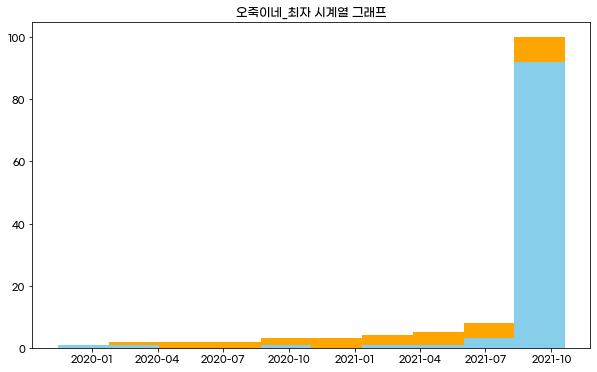

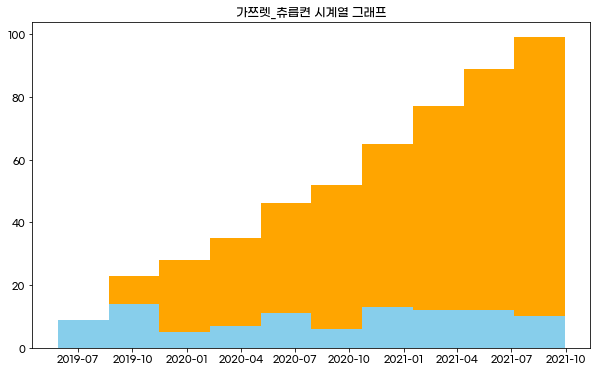

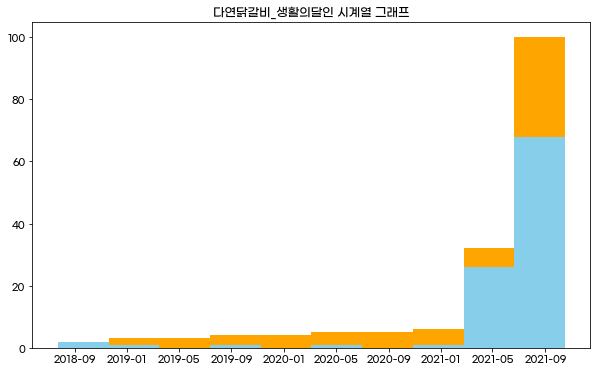

In [18]:
lists = ["오죽이네_최자", "가쯔렛_츄릅켠", "다연닭갈비_생활의달인"]
for item in lists:
    file = "./data/instagram/rowdata/" + item + ".csv"
    temp = pd.read_csv(file)
    temp.sort_values(by = "date", ascending=True, inplace=True)
    temp.date = pd.to_datetime(temp['date'])
    # 기간 나누기
    # temp['period'] = temp['postdate'].dt.to_period(freq='M')  # 년-월
    # 그래프 그리기
    plt.figure(figsize=(10,6))
    temp["test"] = 1
    plt.hist(temp["date"], weights=temp["test"], bins=10, cumulative = True, color="orange")
    plt.hist(temp["date"], weights=temp["test"], bins=10, cumulative = False, color="skyblue")
    plt.title(item + " 시계열 그래프")
    plt.show()

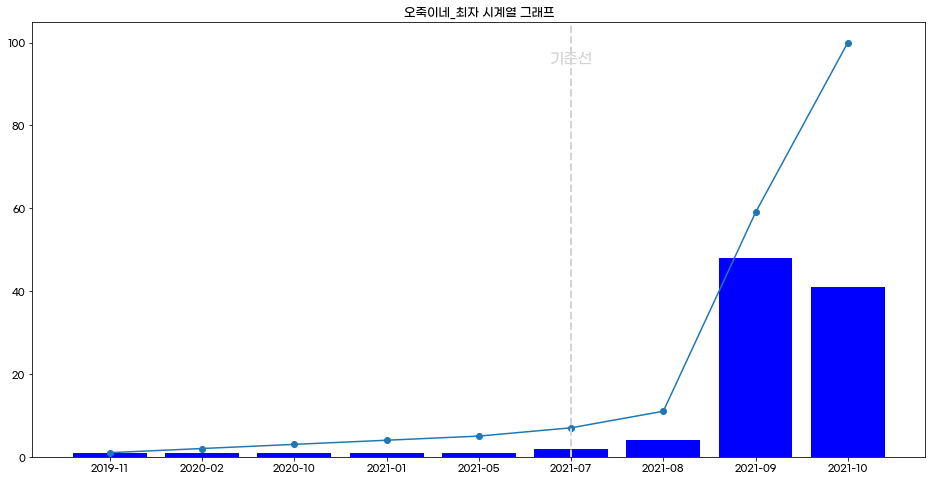

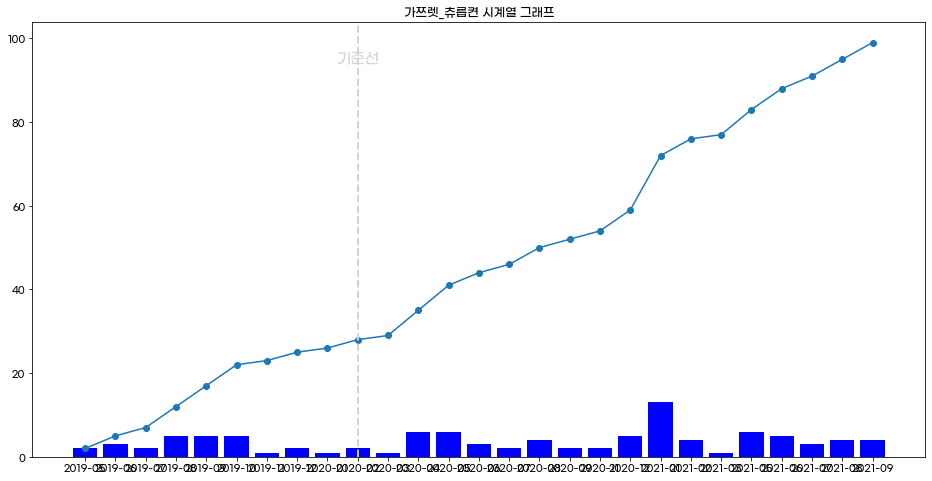

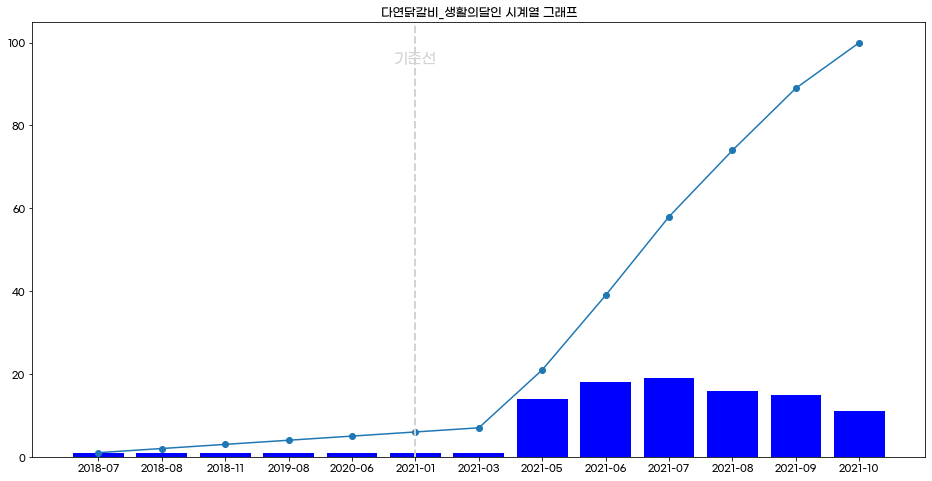

In [19]:
import numpy as np

filelist = ["오죽이네_최자", "가쯔렛_츄릅켠", "다연닭갈비_생활의달인"]
referenceDate = ['2021-07', '2020-02', "2021-01"]
for i in range(len(filelist)):
    file = "./data/instagram/rowdata/" + filelist[i] + ".csv"
    temp = pd.read_csv(file)
    temp.sort_values(by = "date", ascending=True, inplace=True)
    temp.date = pd.to_datetime(temp['date'])
    # 기간 나누기
    temp['period'] = temp['date'].dt.to_period(freq='M')  # 년-월
    # 기간별로 포스트 개수 세기
    period_count = temp.groupby("period").count()[["date"]]
    period_count.rename(columns = {"date": "count"}, inplace=True)
    # 누적합 열 추가하기
    period_count["cum"] = period_count[["count"]].cumsum()
    # 그래프 그리기
    plt.figure(figsize=(16,8))
    # 그래프를 그리기 위한 형변환
    period_count.index=period_count.index.to_series().astype(str)
    # 기준일 색깔 넣기
    my_color = np.where(period_count.index == referenceDate[0], 'skyblue', 'orange')
    # 라인그래프 그리기
    plt.plot(period_count.index, period_count["cum"], marker='o')
    # 기준일 그리기
    plt.axvline(referenceDate[i], color='lightgray', linestyle='--', linewidth=2)
    plt.text(referenceDate[i], period_count["cum"].max() * 0.95, "기준선",       
             fontsize = 15, 
             color='lightgray',
             horizontalalignment='center') 
    # 바그래프 그리기
    plt.bar(period_count.index, period_count["count"], color="blue",align='center')
    plt.title(filelist[i] + " 시계열 그래프")
    plt.savefig('./output/' + filelist[i] + ' 시계열 그래프_instagram.png')
    plt.show()